In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import os
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import random
from copy import deepcopy as copy

from tactile_learning.utils.constants import *


In [11]:

def get_completely_shuffled_tactile_image(tactile_values):
    tactile_image = torch.FloatTensor(tactile_values)
    tactile_image = F.pad(tactile_image, (0,0,0,0,1,0∫), 'constant', 0)
    tactile_image = tactile_image.view(16,4,4,3)
    
    tactile_image = torch.concat([
        torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
        for i in range(4)
    ], dim=1)
    
    copy_tactile_image = copy(tactile_image)
    sensor_idx = list(range(16*16))
    random.seed(10)
    random.shuffle(sensor_idx)
    for i in range(16):
        for j in range(16):
            rand_id = sensor_idx[i*16+j]
            rand_i = int(rand_id / 16)
            rand_j = int(rand_id % 16)
            tactile_image[i,j,:] = copy_tactile_image[rand_i, rand_j, :]

    tactile_image = torch.permute(tactile_image, (2,0,1))
    pre_tactile_transform = T.Compose([
        T.Resize(16),
        T.Lambda(_clamp_transform),
        T.Lambda(_scale_transform)
    ])
    return pre_tactile_transform(tactile_image)

def get_pads_shuffled_tactile_image(tactile_values):
    tactile_image = torch.FloatTensor(tactile_values)
    tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
    tactile_image = tactile_image.view(16,4,4,3)
    shuffled_pad_idx = list(range(16))
    random.seed(10)
    random.shuffle(shuffled_pad_idx)
    print(shuffled_pad_idx)
    
    tactile_image = torch.concat([
        torch.concat([tactile_image[shuffled_pad_idx[i*4+j]] for j in range(4)], dim=0)
        for i in range(4)
    ], dim=1)
    
    tactile_image = torch.permute(tactile_image, (2,0,1))
    pre_tactile_transform = T.Compose([
        T.Resize(16),
        T.Lambda(_clamp_transform),
        T.Lambda(_scale_transform)
    ])
    return pre_tactile_transform(tactile_image)
    

def get_tactile_image_for_visualization(tactile_values, shuffle_type=None):
    def _get_whole_hand_tactile_image(tactile_values): 
        # tactile_values: (15,16,3) - turn it into 16,16,3 by concatenating 0z
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
        # reshape it to 4x4
        tactile_image = tactile_image.view(16,4,4,3)

        # concat for it have its proper shape
        tactile_image = torch.concat([
            torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)

        tactile_image = torch.permute(tactile_image, (2,0,1))
        pre_tactile_transform = T.Compose([
            T.Resize((16,16)),
            T.Lambda(_clamp_transform),
            T.Lambda(_scale_transform)
        ])
        return pre_tactile_transform(tactile_image)

    if shuffle_type is None:
        tactile_image = _get_whole_hand_tactile_image(tactile_values)
    elif shuffle_type == 'pad':
        tactile_image = get_pads_shuffled_tactile_image(tactile_values)
    elif shuffle_type == 'whole':
        tactile_image = get_completely_shuffled_tactile_image(tactile_values)
        
    tactile_image = T.Resize(224)(tactile_image) # Don't need another normalization
    tactile_image = (tactile_image - tactile_image.min()) / (tactile_image.max() - tactile_image.min())
    return tactile_image  

def _clamp_transform(image):
    image = torch.clamp(image, min=TACTILE_PLAY_DATA_CLAMP_MIN, max=TACTILE_PLAY_DATA_CLAMP_MAX)
    return image

def _scale_transform(image):
    image = (image - TACTILE_PLAY_DATA_CLAMP_MIN) / (TACTILE_PLAY_DATA_CLAMP_MAX - TACTILE_PLAY_DATA_CLAMP_MIN)
    return image

In [26]:
from tactile_learning.models.knn import KNearestNeighbors
def get_neighbor_ids(k=10):
    all_representations = deployment_info['all_representations']
    curr_representation = deployment_info['curr_representations'][TESTING_STATE]
    knn = KNearestNeighbors(all_representations, all_representations)
    _, ids = knn.get_k_nearest_neighbors(curr_representation,k=k)
    return ids

In [8]:
def plot_tactile_sensor(ax, sensor_values, use_img=False, img=None, title='Tip Position'):
    # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
    img_shape = (240, 240, 3) # For one sensor
    blank_image = np.ones(img_shape, np.uint8) * 255
    if use_img == False: 
        img = ax.imshow(blank_image.copy())

    # Set the coordinates for each circle
    tactile_coordinates = []
    for j in range(48, 192+1, 48): # Y
        for i in range(48, 192+1, 48): # X - It goes from top left to bottom right row first 
            tactile_coordinates.append([i,j])

    # Plot the circles
    min_sensor = sensor_values.min()

    for i in range(sensor_values.shape[0]):
        center_coordinates = (
            tactile_coordinates[i][0] + int(sensor_values[i,0]/20), # NOTE: Change this
            tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
        )

        radius = max(2, int(np.sqrt(sensor_values[i,2] - min_sensor)))
      
        if i == 0:
            frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
        else:
            frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

    img.set_array(frame_axis)

    return img, frame_axis

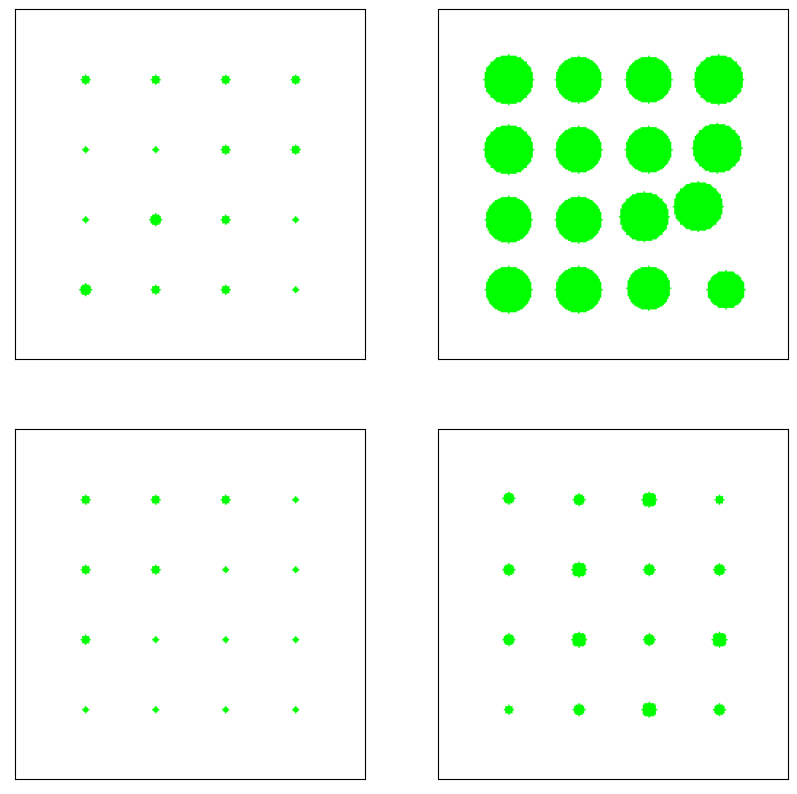

In [9]:

# from tactile_learning.utils.visualization import plot_tactile_sensor


def plot_tactile_state(tactile_values, small_tactile=False):
    if not small_tactile:
        fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
        for col_id in range(4):
            for row_id in range(4):
                if col_id + row_id > 0:
                    plot_tactile_sensor(
                        ax = axs[row_id, col_id],
                        sensor_values = tactile_values[col_id*4+row_id-1],
                        title=f'Finger: {col_id}, Sensor: {row_id}'
                    )
                axs[row_id, col_id].get_yaxis().set_ticks([])
                axs[row_id, col_id].get_xaxis().set_ticks([])
    else:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
        axs_row = 0 
        axs_col = 0
        i = 0
        for col_id in range(4):
            for row_id in range(4):
                if (col_id == 2 and row_id == 0) or \
                   (col_id == 3 and row_id == 0) or \
                   (col_id == 2 and row_id == 1) or \
                   (col_id == 2 and row_id == 2):
                    axs_row = i % 2
                    axs_col = int(i / 2)
                    plot_tactile_sensor(
                        ax = axs[axs_row, axs_col],
                        sensor_values = tactile_values[col_id*4+row_id-1],
                        title=f'Finger: {col_id}, Sensor: {row_id}'
                    )
                    axs[axs_row][axs_col].get_yaxis().set_ticks([])
                    axs[axs_row][axs_col].get_xaxis().set_ticks([])
                    i += 1
        
    # fig.savefig('tactile_state.png', bbox_inches='tight')
    # fig.clf()
    # plt.close()
    plt.show()
    
# plot_tactile_state(deployment_info['tactile_values'][TESTING_STATE], True)

(-0.5, 1279.5, 719.5, -0.5)

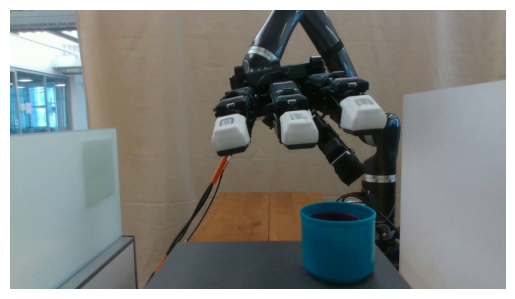

In [18]:
# Get the neighbors - from the data from load_data
import glob
from torchvision.datasets.folder import default_loader as loader

def load_dataset_image(demo_id, image_id, view_num=1, data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/book_opening/eval'):
    roots = glob.glob(f'{data_path}/demonstration_*')
    roots = sorted(roots)
    image_root = roots[demo_id]
    image_path = os.path.join(image_root, 'cam_{}_rgb_images/frame_{}.png'.format(view_num, str(image_id).zfill(5)))
    img = T.ToTensor()(loader(image_path)).permute(1,2,0) # We don't have to do these for this particular thinb
    return img.numpy()

# data_path = '/data/tactile_learning/deployment_data/book_opening/demonstrations/image_tactile_play_1min'
# data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/book_opening/eval'
# image = load_dataset_image(demo_id=0, image_id=70, view_num=1, data_path='/home/irmak/Workspace/Holo-Bot/extracted_data/cup_picking/eval')
# plt.imshow(image)
# plt.axis('off')


In [13]:
from tactile_learning.utils.augmentations import get_tactile_augmentations
from tactile_learning.utils.constants import *
augment_fn = augment_fn = get_tactile_augmentations(
    img_means = TACTILE_IMAGE_MEANS,
    img_stds = TACTILE_IMAGE_STDS,
    img_size = (224, 224)
)



import numpy as np

np_means = np.asarray(VISION_IMAGE_MEANS)
np_stds = np.asarray(VISION_IMAGE_STDS)

inv_image_transform = T.Compose([
    T.Normalize(mean = [0,0,0], std = 1 / np_stds ), 
    T.Normalize(mean = -np_means, std = [1,1,1])
])

In [12]:
import random 
random.seed(10)
x = list(range(16))
idx = random.shuffle(x)
print(x)

tactile_image = get_tactile_image_for_visualization(deployment_info['tactile_values'][TESTING_STATE], shuffle_type='whole')
plt.axis('off')
plt.imshow(np.transpose(tactile_image, (1,2,0)))

augmented_plt = augment_fn(tactile_image)
augmented_plt = (augmented_plt - augmented_plt.min()) / (augmented_plt.max() - augmented_plt.min())
plt.imshow(np.transpose(augmented_plt, (1,2,0)))
plt.axis('off')

In [19]:
from tactile_learning.utils.data import load_data

# data_path = '/home/irmak/Workspace/Holo-Bot/extracted_data/bottle_cap_opening/eval'
data_path = '/data/tactile_learning/bottle_cap_opening/eval'
roots = glob.glob(f'{data_path}/demonstration_*')
data = load_data(roots, demos_to_use=[])
def get_data_with_id_for_visualization(id):
    demo_id, tactile_id = data['tactile']['indices'][id]
    _, allegro_tip_id = data['allegro_tip_states']['indices'][id]
    _, kinova_id = data['kinova']['indices'][id]
    _, image_id = data['image']['indices'][id]
    tactile_values = data['tactile']['values'][demo_id][tactile_id]
    tactile_image = get_tactile_image_for_visualization(tactile_values)
    allegro_finger_tip_pos = data['allegro_tip_states']['values'][demo_id][allegro_tip_id]
    kinova_cart_pos = data['kinova']['values'][demo_id][kinova_id][:3]
    image = load_dataset_image(demo_id, image_id, view_num=1, data_path=data_path)
    # image_cv2 = cv2.cvtColor(image*255, cv2.COLOR_RGB2BGR)

    visualization_data = dict(
        image = image,
        kinova = kinova_cart_pos, 
        allegro = allegro_finger_tip_pos, 
        tactile_values = tactile_values,
        tactile_image = tactile_image
    )

    return visualization_data

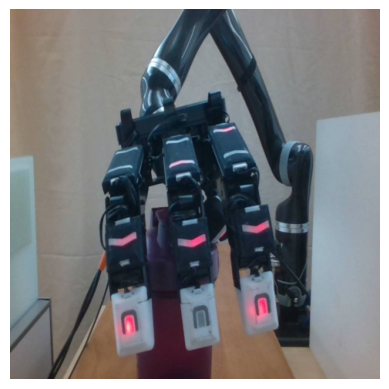

In [16]:
import cv2
def plot_curr_image(image): # - NOTE: maybe we could plot the images from the saved deployments
    image = inv_image_transform(image).numpy().transpose(1,2,0)
    image_cv2 = cv2.cvtColor(image*255, cv2.COLOR_RGB2BGR)
    # cv2.imshow(image_cv2)
    plt.imshow(image)
    plt.axis('off')
plot_curr_image(deployment_info['images'][TESTING_STATE])

In [4]:
# Script to plot the neigjhbors and tactile values afterwards from the deployment info
deployment_data_dir = '/home/irmak/Workspace/Holo-Bot/deployment_data/bottle_cap_opening/demo_images/image/1'


with open(os.path.join(deployment_data_dir, 'deployment_info.pkl'), 'rb') as f: 
    deployment_info = pickle.load(f)

In [5]:
deployment_info.keys()

dict_keys(['all_representations', 'curr_representations', 'closest_representations', 'neighbor_ids', 'images', 'tactile_values'])

In [6]:
# Plot the neighbors
TESTING_STATE = 34 # 0,1,2,3,4,5,8,10,14,18,20
len(deployment_info['images'])
len(deployment_info['tactile_values'])

42

In [27]:
neighbor_id = deployment_info['neighbor_ids'][TESTING_STATE]
neighbor_ids = get_neighbor_ids()
neighbor_next_id = neighbor_id+1

In [28]:
print(neighbor_id, neighbor_next_id, neighbor_ids)

74 75 [ 74  73   9  10 113   8  13   7 119  11]


In [22]:
neighbor_vis_data = get_data_with_id_for_visualization(neighbor_id)
neighbor_next_vis_data = get_data_with_id_for_visualization(neighbor_next_id)

(-0.5, 1279.5, 719.5, -0.5)

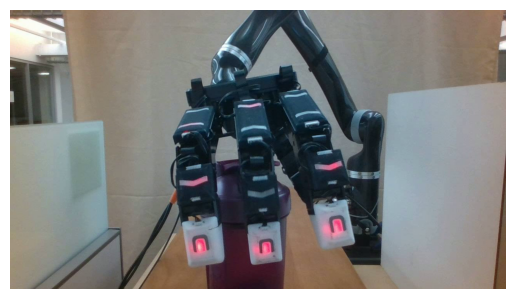

In [23]:
plt.imshow(neighbor_vis_data['image'])
plt.axis('off')

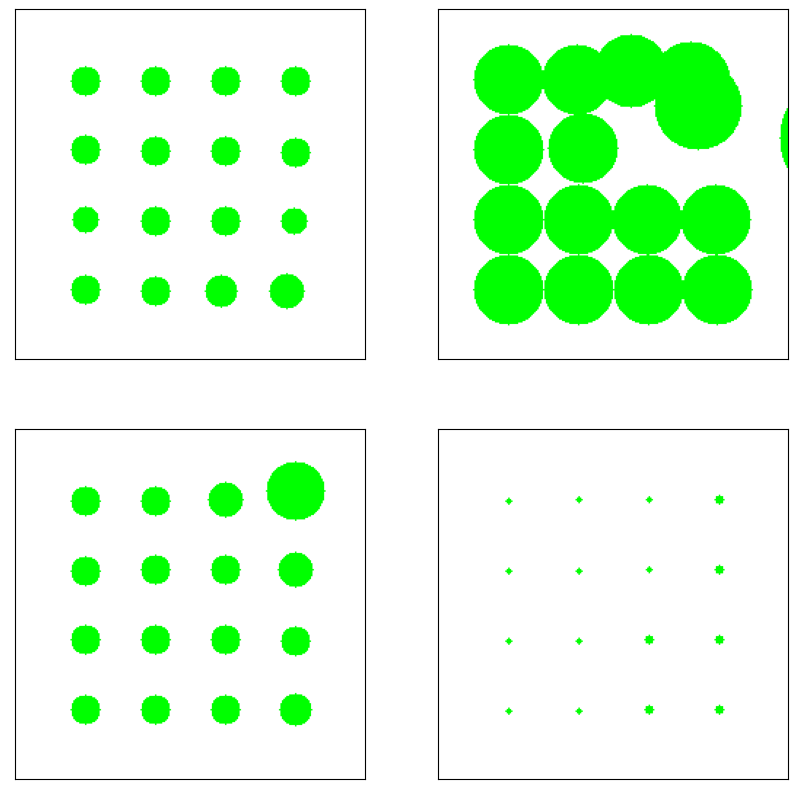

In [199]:
plot_tactile_state(neighbor_vis_data['tactile_values'], True)

(-0.5, 1279.5, 719.5, -0.5)

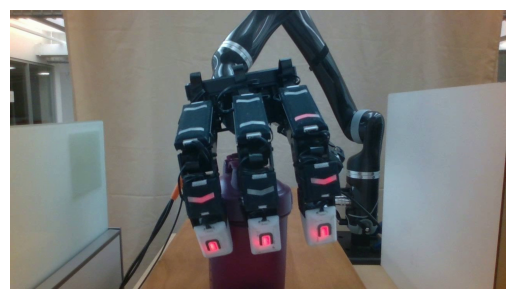

In [131]:
plt.imshow(neighbor_next_vis_data['image'])
plt.axis('off')

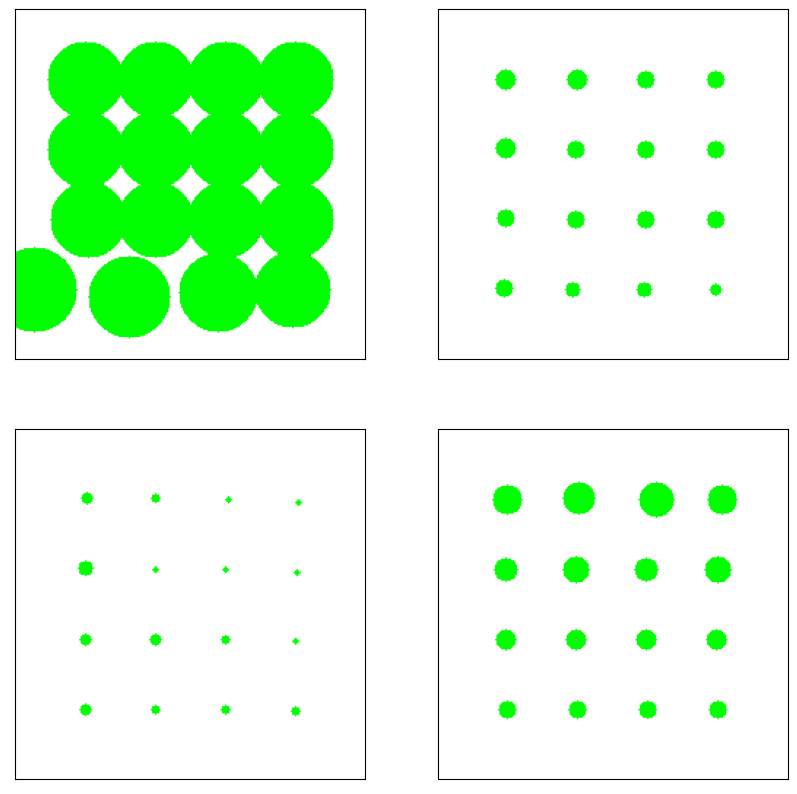

In [69]:
plot_tactile_state(neighbor_next_vis_data['tactile_values'])